# Data Mining Final Project: People Analytics - IBM HR Dataset

## Script Overview: 

### Abstract
+ **Project goals**: 
  - Apply data mining methods on fictitious IBM employee data to derive answers to the following questions:
    - Understand which employees are leaving, in terms of characteristics and experiences
    - Predict which current employees are at risk of leaving
    - How we might specifically retain top performers (i.e. Is there anything unique about them? Can we capture that extra cost in our model?)
    - Determine which levers the company can use to reduce attrition going forward (particularly for top performers)
+ **Description of data**: 
  - 34 numerical and categorical features of employees and a single column that indicates whether or not they have left the company (attrition)
+ **Variable definitions**:
  - https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/discussion/86957
+ **Assumptions**:
  - The dataset provides a picture of an entire organization at multiple management levels
  - Attrition metric accounts only for people leaving voluntarily (e.g. retirement, switching companies)
+ **Methods**:
  - Done: Logistic regression and SVM
  - EDA, Pipelines, Feature engineering, Ensemble learning, PCA and Dimensionality reduction (t-SNE), Hierarchical clustering, Classification, Logistic regression, Random forest, Gradient boosting, Regression, PCA, agglomerative clustering, t-SNE, Model evaluation (TODO extrapolate?), Loss function
+ **Limitations and risks**: 
  - Need to be very careful when using HR data. If not careful, may make illegal decisions related to employment law or using health data. Important to work with HR compliance/HR Legal. For that reason, should NOT be used for firing decisions. Should be used for internal employee experience improvement primarily.
+ **Summary of conclusions**: 
  - TODO
    - Which employees are likely to leave?
    - Answer the question of how we might specifically retain top performers (i.e. Is there anything unique about them? Can we capture that extra cost in our model?)
    - Understand which employees are leaving, in terms of characteristics and experiences
    - Predict which current employees are at risk of leaving
    - Determine which levers the company can use to reduce attrition going forward (particularly for top performers)


### Table of Contents
+ **Step 1**: Environment set-up and data load
+ **Step 2**: Exploratory data analysis (EDA) and data processing
+ **Step 3**: Dimensionality reduction
+ **Step 4**: Clustering
+ **Step 5**: Linear classification models
+ **Step 6**: Non-linear classification models
+ **Step 7**: Final Visualizations
+ **Step 8**: SMOTE analysis (dealing with imbalanced data)


### STILL TO DO
+ Everyone: Write-up under your sections - general findings and any outstanding work needed
+ Everyone: Step 3 & 4 need to be integrated into master file
+ Michael & Nick: SMOTE analysis
+ Matt: Loss function for high performers
+ Michael: Add Random forest with class weight param based on ratio of churners and non-churners
+ Nic: Decision Tree with bagging and boosting

## Step 1: Environment set-up and data load

In [2]:
# Data processing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import stats
from numpy import mean
from numpy import std

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from pandas.plotting import scatter_matrix

# Model functions
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold



# Ignore Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df  = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Step 2: EDA and data processing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
# Getting a sense of how many categories we're dealing with
print(df['Attrition'].unique())
print(df['BusinessTravel'].unique())
print(df['Department'].unique())
print(df['EducationField'].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']


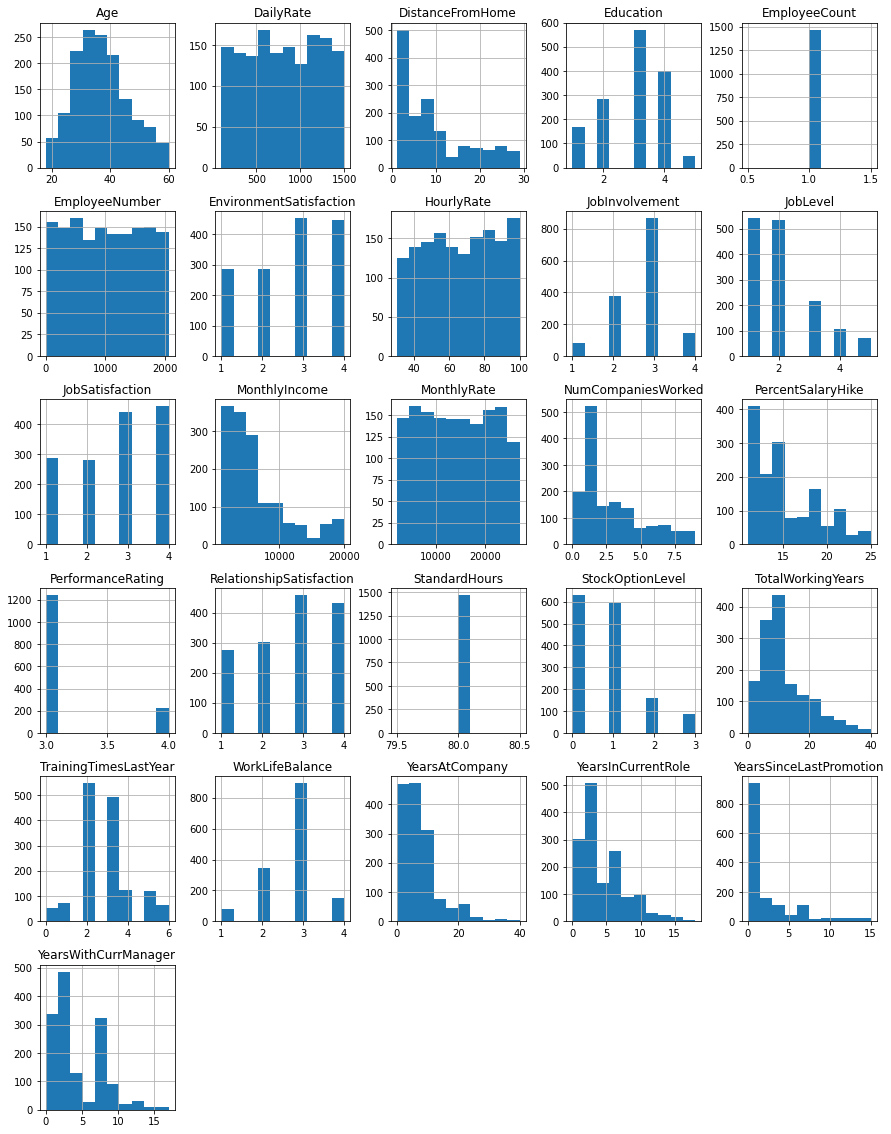

In [8]:
# Plotting distributions
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
df.hist(ax = ax)
pass # Added to hide the plot messages

# Imbalanced training set we''ll need to address (1200 still there, 200 attritioned)
# Most employees are close to the office (within 10 miles)

# Education, Environment Satisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, 
# RelationshipSatisfaction, WorkLifeBalance should also probably be treated as categorical 

In [9]:
#TODO plot attrition by subgroups --> consider adding attrition into corr plot

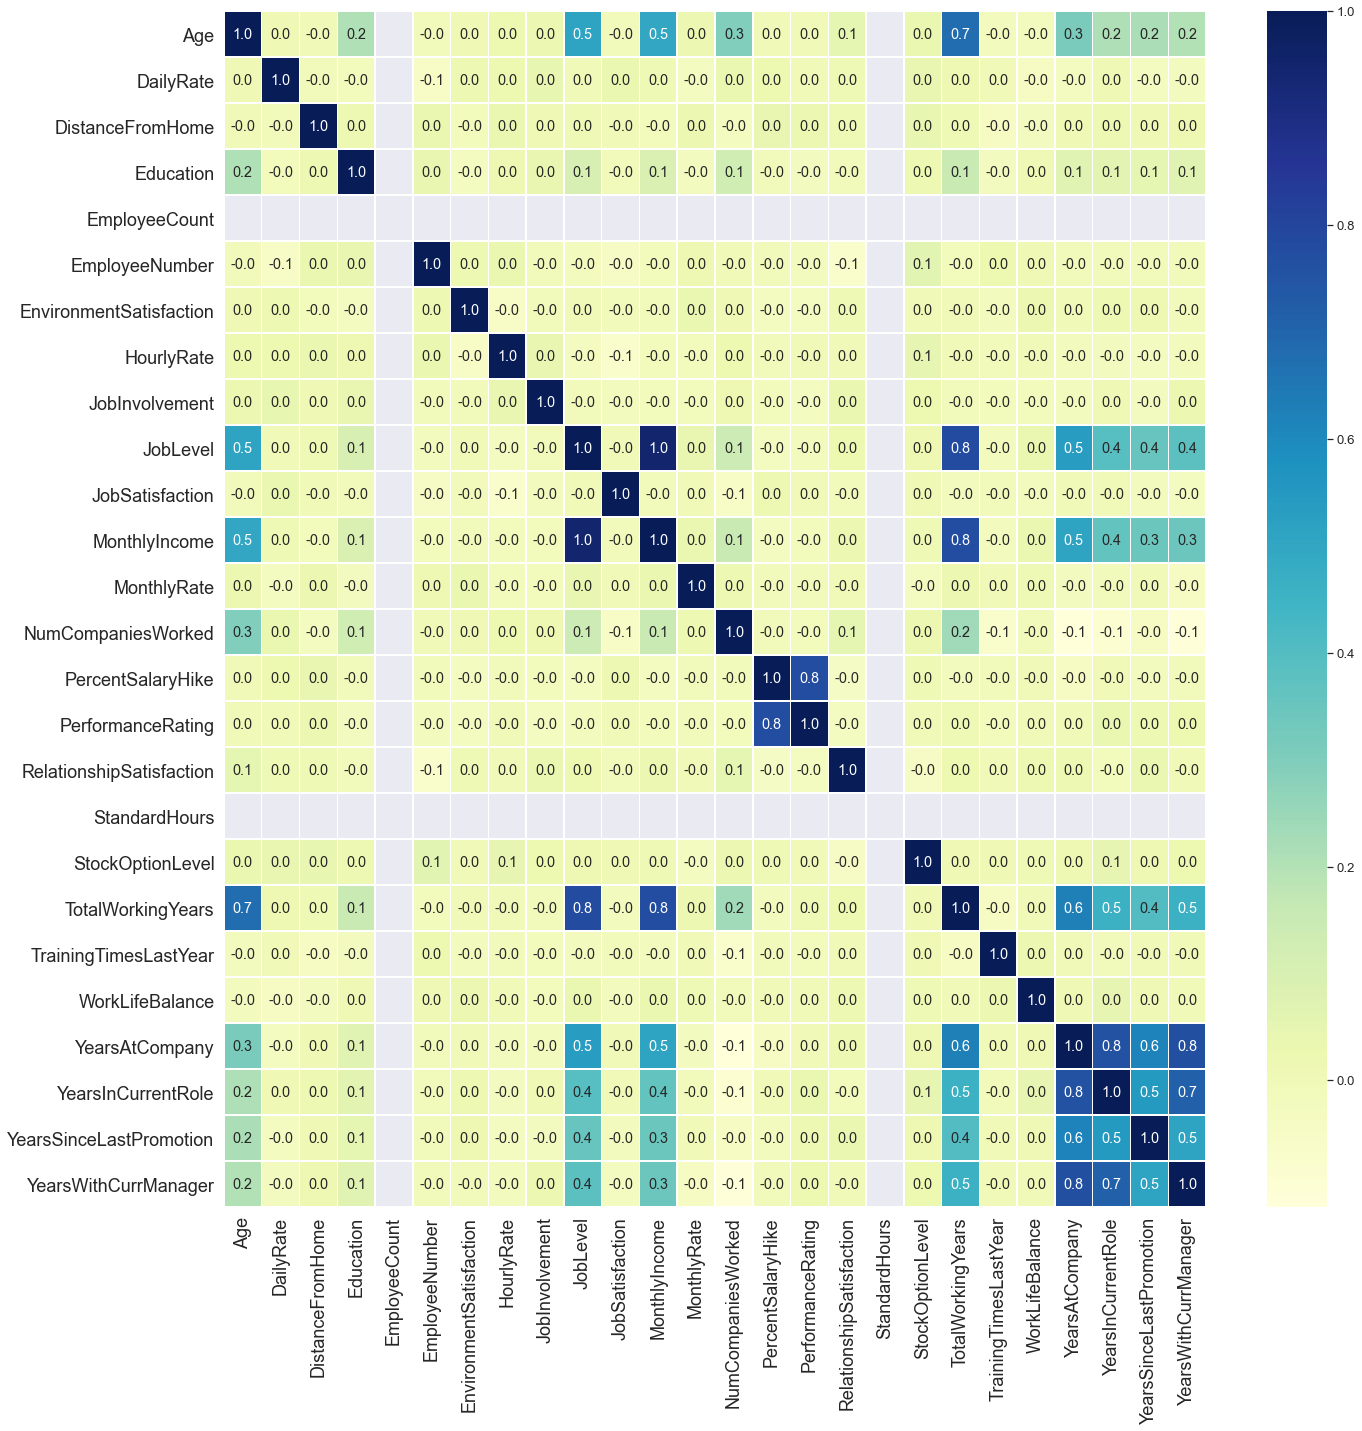

In [10]:
# Heatmap of correlations
# Low correlation for most fields, dispelling some concerns about multicollinearity. Should be able to use all predictors
sns.set(font_scale=1.2)# Increase font size of corr values

f,ax = plt.subplots(figsize=(22, 22))
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="YlGnBu")
pass

In [11]:
# Using a scatter matrix to visualize correlations
# TODO - if using, need to select only first 30 or so features since new features are not at all correlated
# pd.plotting.scatter_matrix(df, figsize=(15, 15))
# fig=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
# plt.show()

In [12]:
# Create a label encoder object
le = LabelEncoder()

In [13]:
plt.rcParams['figure.figsize'] = (18,18)
print('Size of initial unencoded dataset (categorical columns intact): {}'. format(df.shape))
df.head()

Size of initial unencoded dataset (categorical columns intact): (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [14]:
# Label Encoding will be used for columns with 2 or less unique values - creates new binary columns for their unique values
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

4 columns were label encoded.


In [15]:
# convert rest of categorical variable into dummy
df = pd.get_dummies(df, drop_first=True)
print('Size of Full Encoded Dataset (new binary columns created): {}'. format(df.shape))
df.head()
# df.info()

Size of Full Encoded Dataset (new binary columns created): (1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [16]:
# Creating our target dataframe
target = df['Attrition'].copy()

# Drpoping attrition
print('Size of Full dataset is: {}'.format(df.shape))
df.head()
# A lot of kernels suggest also dropping these 'redundant' features. #TODO Look into why these are considered redundant
# df['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'']

Size of Full dataset is: (1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [17]:
np.save('data/attrition_data_transformed', df)

In [18]:
# Now is where we'll address the fact that our dataset is not balanced regarding the number of attrition versus non-attrition (data imbalance)
# Stratify helps maintain a ratio in the training set

# IMPORT
reduced = np.load('data/attrition_data_transformed.npy')


# -------------------- COPY AND PASTE THE CODE BELOW FOR YOUR TEST/TRAIN --------------------
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)

X_train.drop(['Attrition'],axis=1,inplace=True)
X_test.drop(['Attrition'],axis=1,inplace=True)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1102, 48)
Number transactions y_train dataset:  (1102,)
Number transactions X_test dataset:  (368, 48)
Number transactions y_test dataset:  (368,)


## Step 3: Dimensionality reduction

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


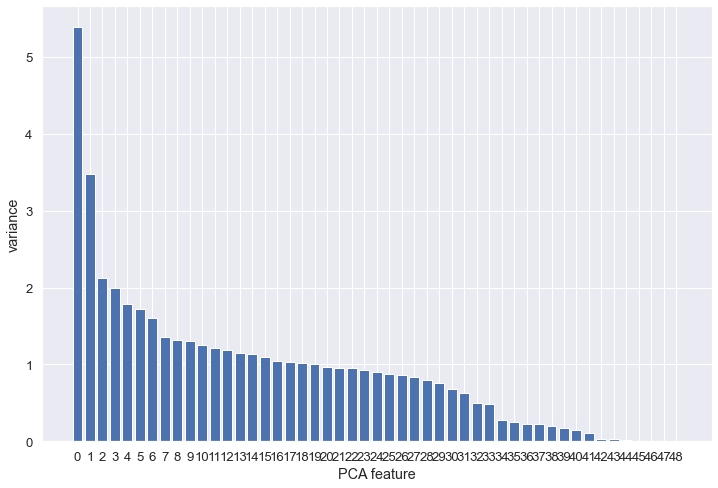

In [20]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(df)
features = range(pca.n_components_)
plt.figure(figsize=(12,8))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()
var = pca.explained_variance_ratio_ * 100

In [21]:
for num in range(len(var)):
    print(num, "Variable(s) Explains")
    print(sum(var[0:num]))

0 Variable(s) Explains
0
1 Variable(s) Explains
11.704799709058872
2 Variable(s) Explains
19.258247357116083
3 Variable(s) Explains
23.860426675247748
4 Variable(s) Explains
28.190330299346385
5 Variable(s) Explains
32.07779771445259
6 Variable(s) Explains
35.82765797882039
7 Variable(s) Explains
39.325836502239845
8 Variable(s) Explains
42.26731997577994
9 Variable(s) Explains
45.14410790155267
10 Variable(s) Explains
47.97125282768422
11 Variable(s) Explains
50.693147714470314
12 Variable(s) Explains
53.32664863063627
13 Variable(s) Explains
55.910920693086524
14 Variable(s) Explains
58.406988398227426
15 Variable(s) Explains
60.88508546191831
16 Variable(s) Explains
63.26813547290806
17 Variable(s) Explains
65.52879239201643
18 Variable(s) Explains
67.77020264660736
19 Variable(s) Explains
69.99479330383582
20 Variable(s) Explains
72.1745571573486
21 Variable(s) Explains
74.28761644190486
22 Variable(s) Explains
76.36277190130208
23 Variable(s) Explains
78.42878532151214
24 Variable

Based on the PCA analysis, there doesn't appear to be a great opportunity to reduce the dimensionality of the dataset. To explain 85% of the variation, it would be necessary to keep the dimensions to 27 out of the 48 total features.

T-SNE Analysis

In [22]:
#Move Attrition to first column
cols = list(df)
cols.insert(0, cols.pop(cols.index('Attrition')))

In [154]:
df2 = df.loc[:, cols]
df2.head()

,Attrition,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,1,41,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,0,49,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,1,37,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,0,33,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,0,27,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [155]:
d2 = df.iloc[:,1:-1]
attrition = df.iloc[:,0].astype('category').cat.codes

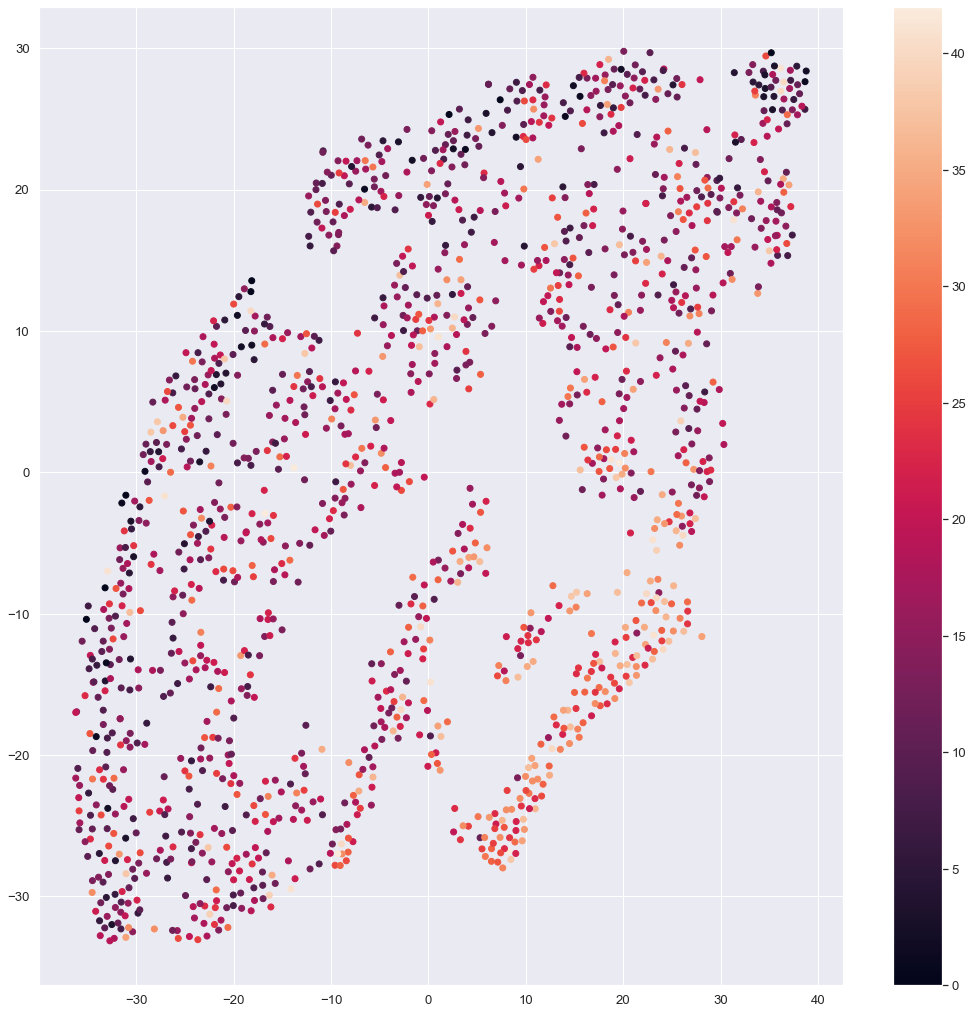

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
model=TSNE(learning_rate=1000, perplexity=50)
Tsne_transformed=model.fit_transform(df2)

xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]
plt.scatter(xs,ys, c = attrition)
plt.colorbar()
plt.show()

## Step 4: Clustering

## Step 5: Linear classification models

#### Decision Trees

In [28]:
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# For reference: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [29]:
dfValues=X_train.values
normalized_dfValues = preprocessing.normalize(dfValues)
plt.figure(figsize=(15,12))

# Calculate the linkage: mergings
mergings = linkage(normalized_dfValues, method='ward')

# generate the linkage matrix
Z = linkage(normalized_dfValues, 'ward')

<Figure size 1080x864 with 0 Axes>

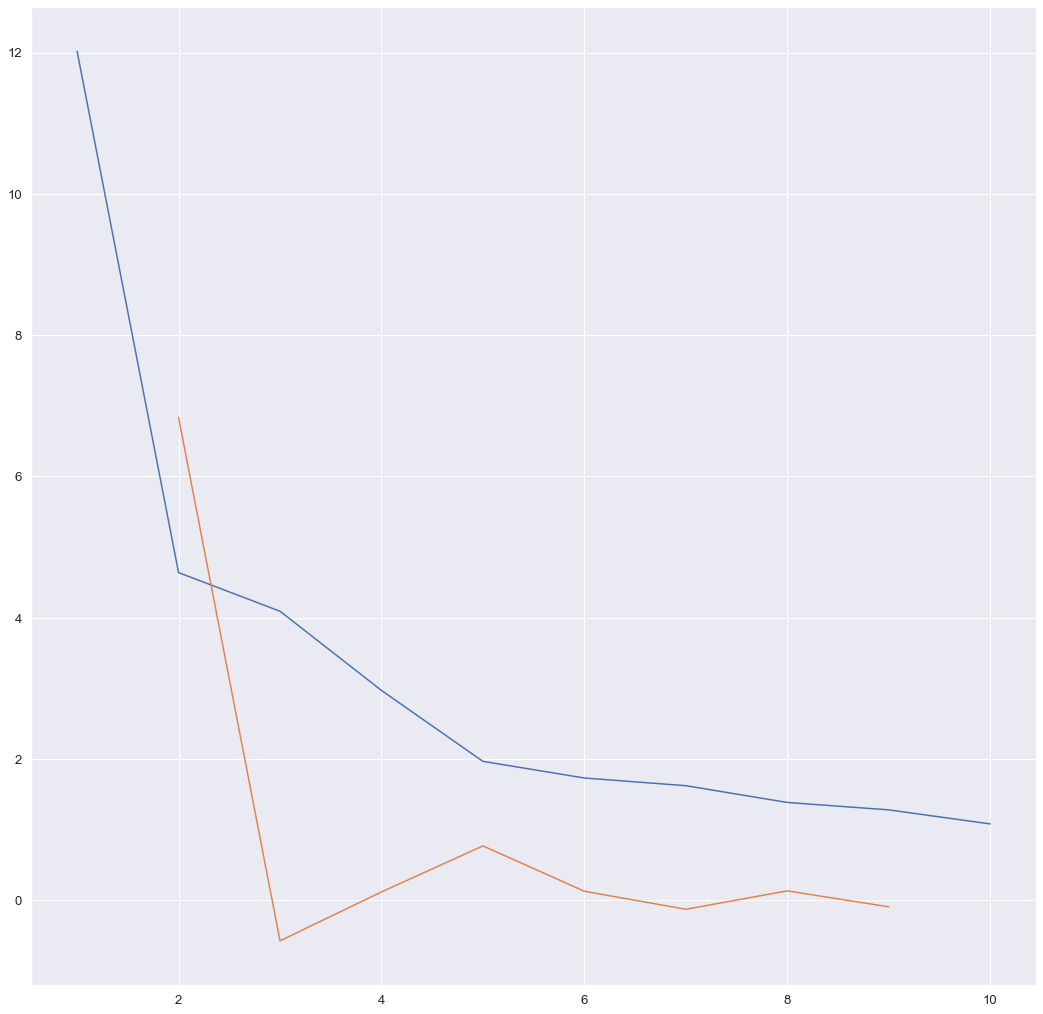

clusters: 2


In [30]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

# Interpretation: The "strongest elbow" of the blue line graph below, is the highest value of the orange graph below

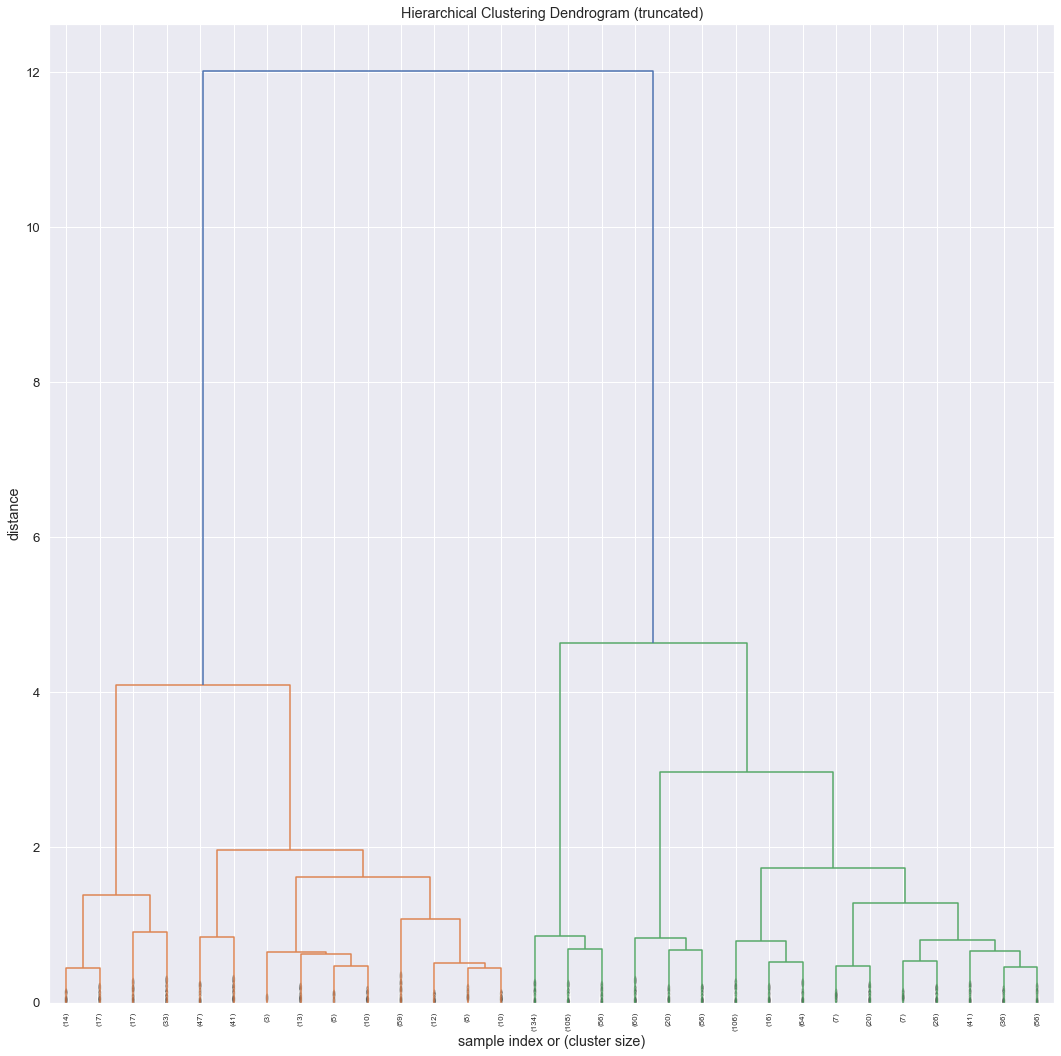

<Figure size 864x720 with 0 Axes>

In [31]:
labels = fcluster(mergings, 70, criterion='distance')

# Plot the dendrogram
dendrogram(
    mergings,
    show_contracted=True,
    truncate_mode='lastp',
    #labels=labels, # TODO fix
    leaf_rotation=90.,
    leaf_font_size = 8
)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.figure(figsize=(12,10))
plt.show()

In [32]:
k=2 # Identified that we have two main clusters above
clusterIDs = fcluster(Z, k, criterion='maxclust') # Create our cluster ids
clusteredTrainXData = pd.DataFrame(dfValues, columns=X_train.columns)
clusteredTrainXData["Cluster"] = clusterIDs # Create new column for clusters
clusteredTrainXData.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Cluster
0,36,1174,3,4,1,1425,1,0,99,3,...,0,0,0,0,0,1,0,0,1,2
1,21,546,5,1,1,1623,3,1,97,3,...,0,0,0,0,1,0,0,0,1,2
2,43,422,1,3,1,902,4,0,33,3,...,0,0,0,0,0,0,0,1,0,2
3,42,188,29,3,1,1148,2,1,56,1,...,1,0,0,0,0,0,0,0,1,2
4,35,992,1,3,1,1564,4,1,68,2,...,1,0,0,0,0,0,0,0,1,2


#### Finally, lets evaluate the accuracy and precision of our hierarchical clustering model

In [33]:
# TODO - evaluation methods .... precision, accuracy, density?
# TODO - what do we know about the people in these clusters? 
#      - How do we do this? Plot the mean delta between each cluster's features?

#### Applying t-SNE to visualize our high dimensional data

It appears we have two main clusters, so I'll now extract the cluster value for each and add it back to a dataframe

In [34]:
# For simplicity of code re-use, I'm moving my cluster column to be the first column in the df
cols = list(clusteredTrainXData.columns)
cols = [cols[-1]] + cols[:-1]
clusteredTrainXData = clusteredTrainXData[cols]
clusteredTrainXData.head()

,Cluster,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,2,36,1174,3,4,1,1425,1,0,99,...,0,0,0,0,0,0,1,0,0,1
1,2,21,546,5,1,1,1623,3,1,97,...,0,0,0,0,0,1,0,0,0,1
2,2,43,422,1,3,1,902,4,0,33,...,0,0,0,0,0,0,0,0,1,0
3,2,42,188,29,3,1,1148,2,1,56,...,0,1,0,0,0,0,0,0,0,1
4,2,35,992,1,3,1,1564,4,1,68,...,0,1,0,0,0,0,0,0,0,1


In [35]:
from sklearn.preprocessing import StandardScaler

tsnedata = clusteredTrainXData
myLabels = tsnedata.iloc[:,0:1]
numericdata = tsnedata.iloc[:,1:-1]
data = StandardScaler().fit_transform(numericdata)
tsnedata.head()
# myLabels.head()
# numericdata.head()
# tsnedata.head()

,Cluster,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,2,36,1174,3,4,1,1425,1,0,99,...,0,0,0,0,0,0,1,0,0,1
1,2,21,546,5,1,1,1623,3,1,97,...,0,0,0,0,0,1,0,0,0,1
2,2,43,422,1,3,1,902,4,0,33,...,0,0,0,0,0,0,0,0,1,0
3,2,42,188,29,3,1,1148,2,1,56,...,0,1,0,0,0,0,0,0,0,1
4,2,35,992,1,3,1,1564,4,1,68,...,0,1,0,0,0,0,0,0,0,1


t-SNE doesn't give me much confidence in my hierarchical clustering model... By color coding our different clusters from the hierarchical model in the t-SNE representation of all our data flattened and clustered, there seems to be a lot of cross pollination...

# TODO TALK ABOUT THIS AS A GROUP

In [36]:
types=myLabels['Cluster'].astype('category').cat.codes

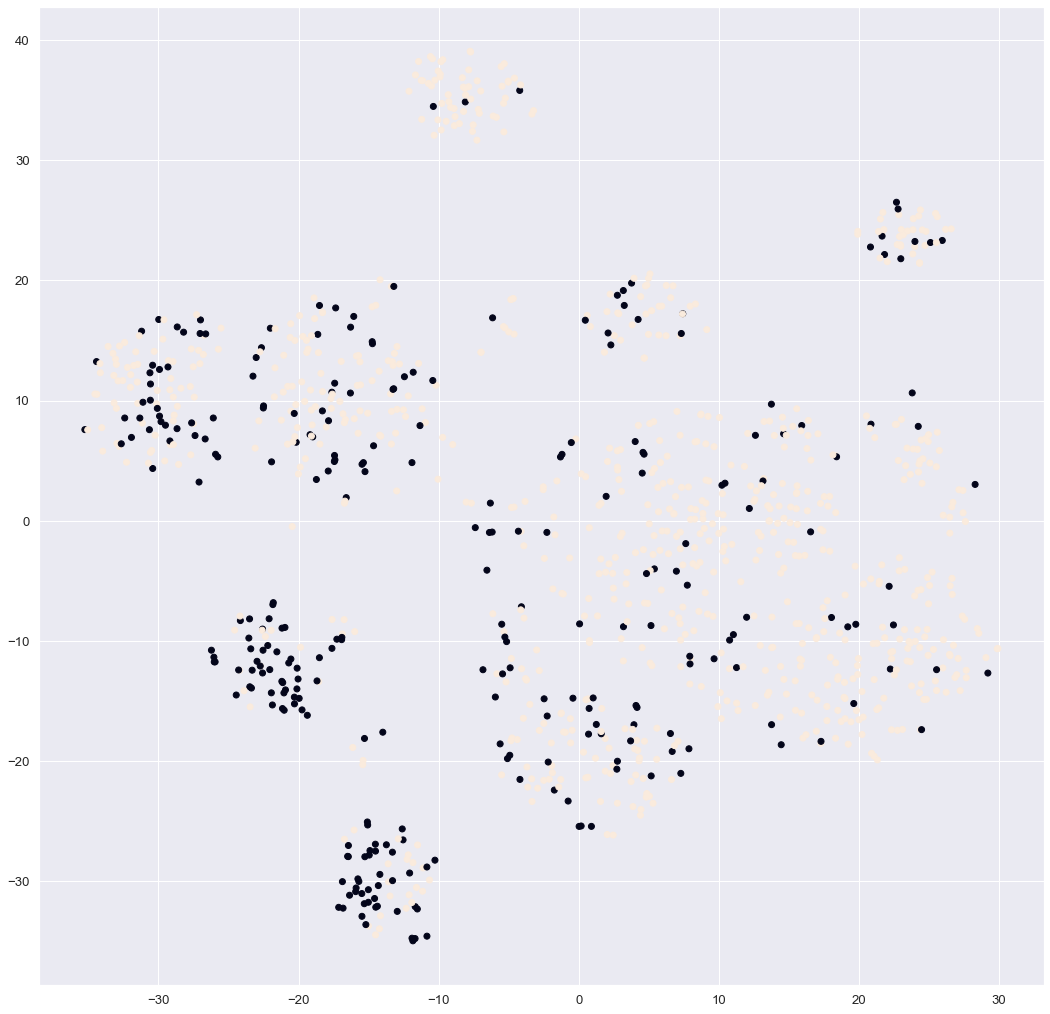

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
model=TSNE(learning_rate=10)

Tsne_transformed=model.fit_transform(data)

xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]
plt.scatter(xs,ys, c=types)
plt.show()

#### SVM

In [38]:
from sklearn.svm import LinearSVC

In [39]:
model_svc = LinearSVC()

model_svc.fit(X_train, y_train)

#Gonna need some way to figure out the balance issue here
y_pred = model_svc.predict(X_test)

In [40]:
acc_svc = round(model_svc.score(X_test, y_test)*100, 2)
print(str(acc_svc) + ' percent')

83.97 percent


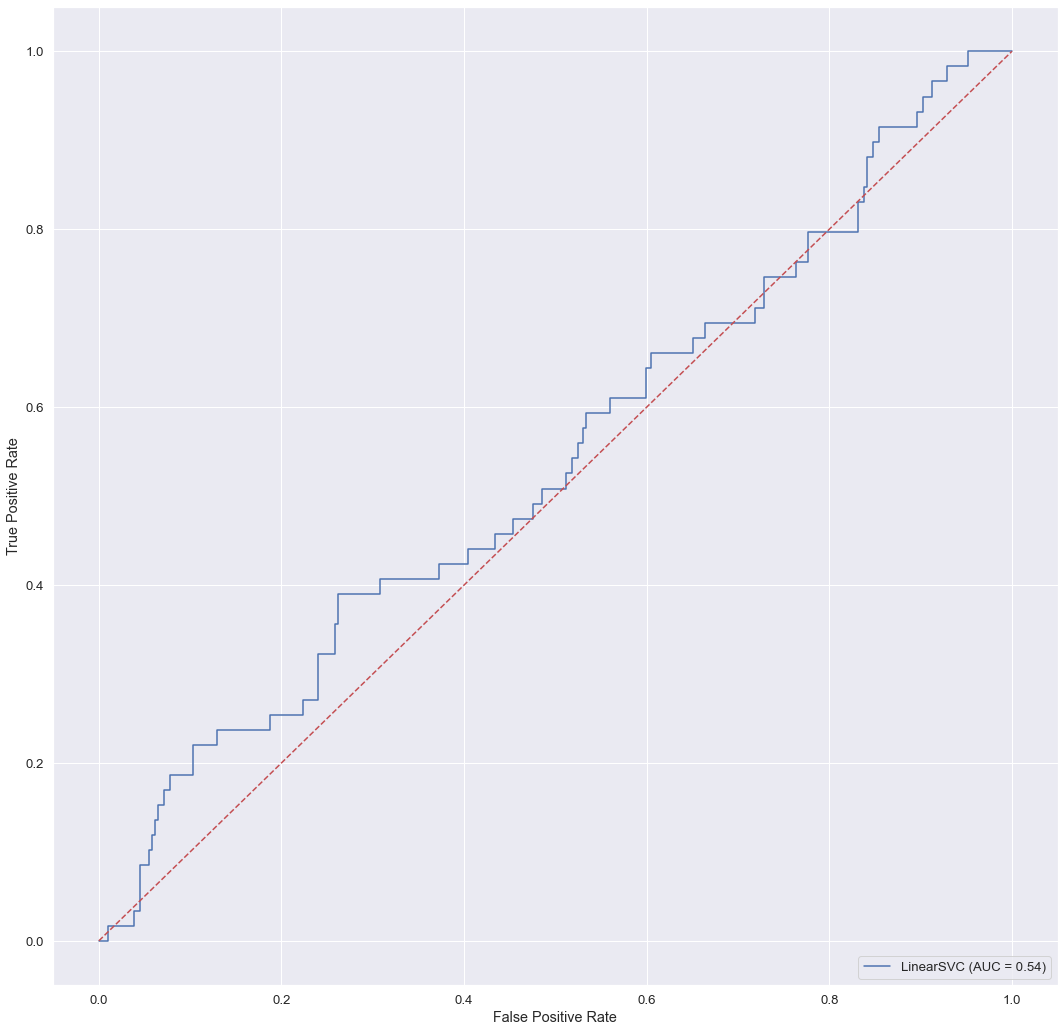

In [41]:
metrics.plot_roc_curve(model_svc, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Text(0.5, 1144.48, 'Predicted label')

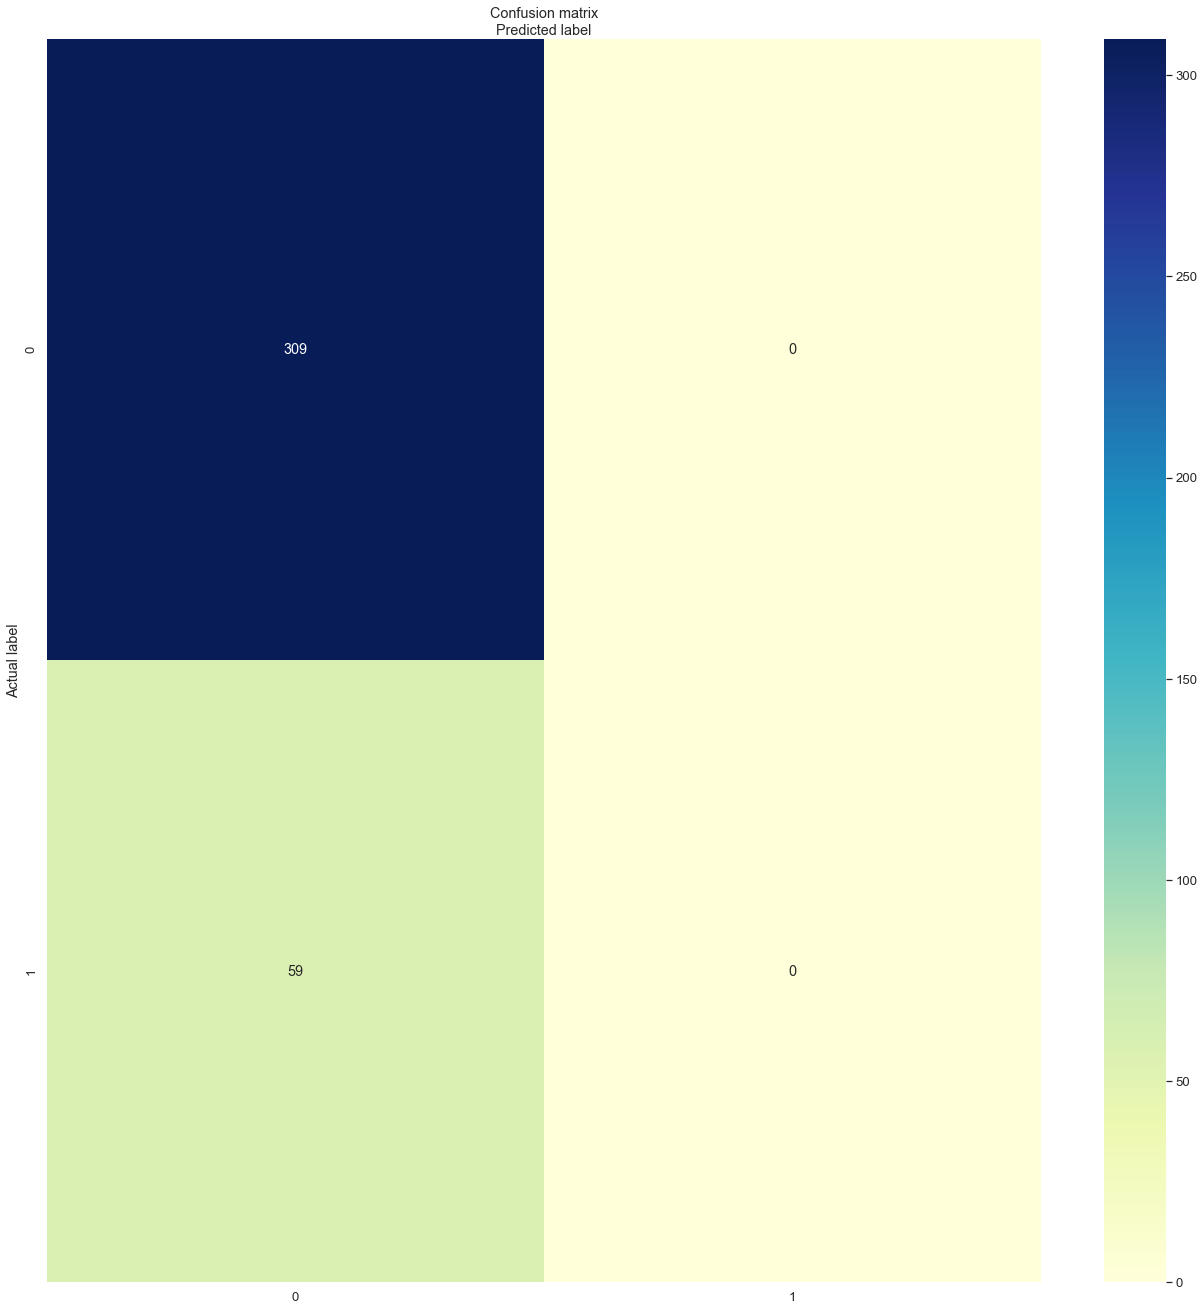

In [42]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Logisitic Regression

In [43]:
import statsmodels.api as sm
from scipy import stats

In [44]:
feature_cols = ['Age', 'Education', 'YearsInCurrentRole', 'YearsAtCompany']

X_train_lr = X_train[feature_cols] 
X_test_lr = X_test[feature_cols] 

In [45]:
model_lr_sm = sm.Logit(y_train, X_train_lr).fit()

print(model_lr_sm.summary())

Optimization terminated successfully.
         Current function value: 0.420604
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Aug 2020   Pseudo R-squ.:                 0.04881
Time:                        16:17:08   Log-Likelihood:                -463.51
converged:                       True   LL-Null:                       -487.29
Covariance Type:            nonrobust   LLR p-value:                 2.624e-10
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0411      0.007     -5.695      0.000      -0.055      -0.027
Educa

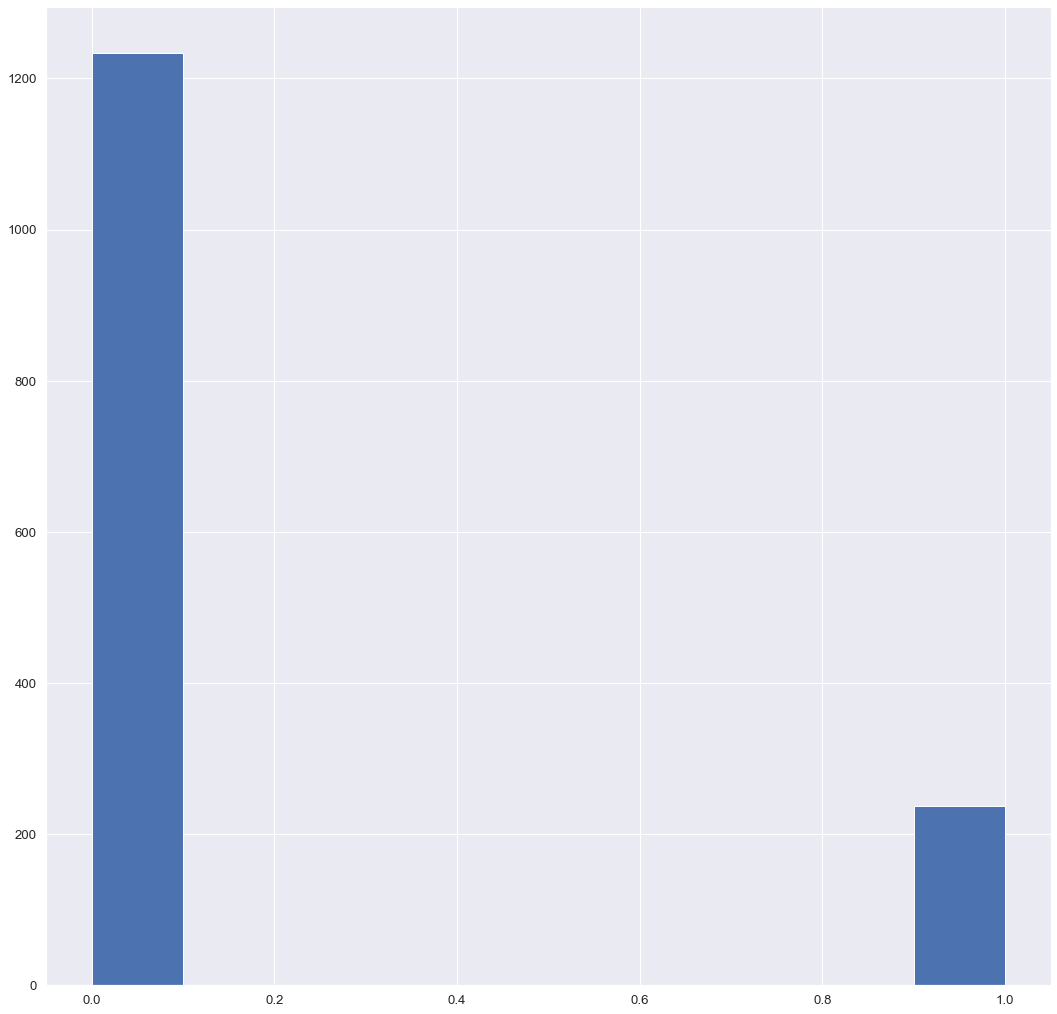

In [46]:
df.Attrition.hist()

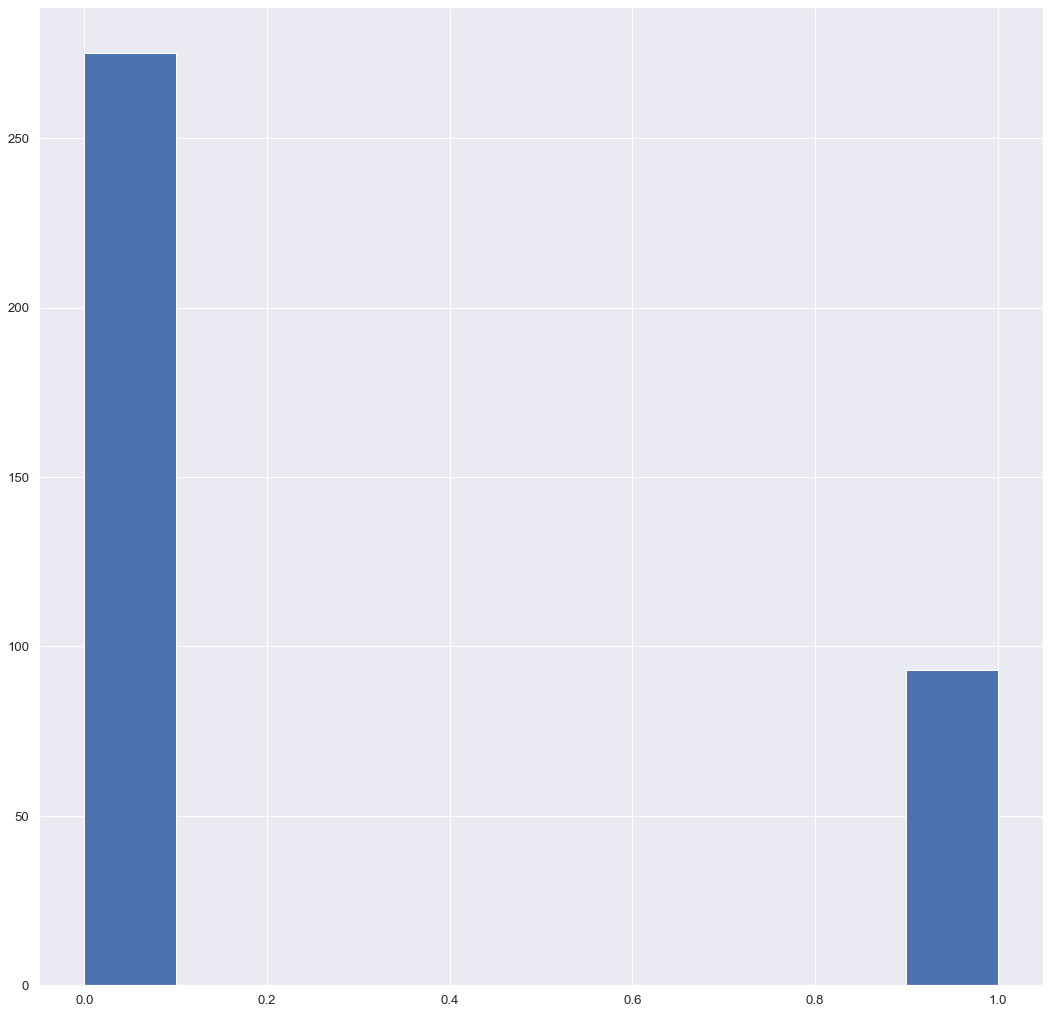

In [47]:
threshold = .1
y_pred = np.where(model_lr_sm.predict(X_test_lr) < threshold, 1, 0)

pd.Series(y_pred).hist()

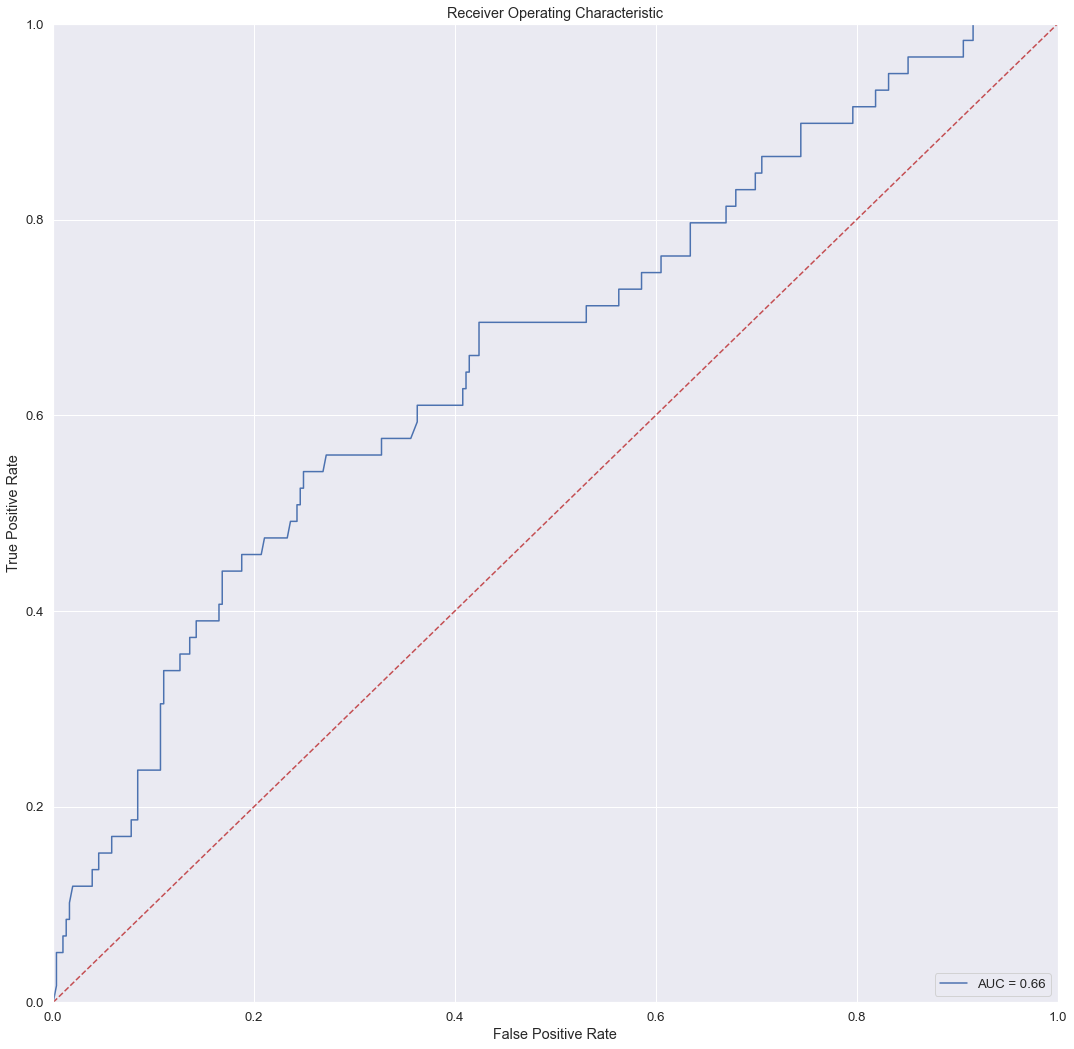

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,model_lr_sm.predict(X_test_lr))
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1144.48, 'Predicted label')

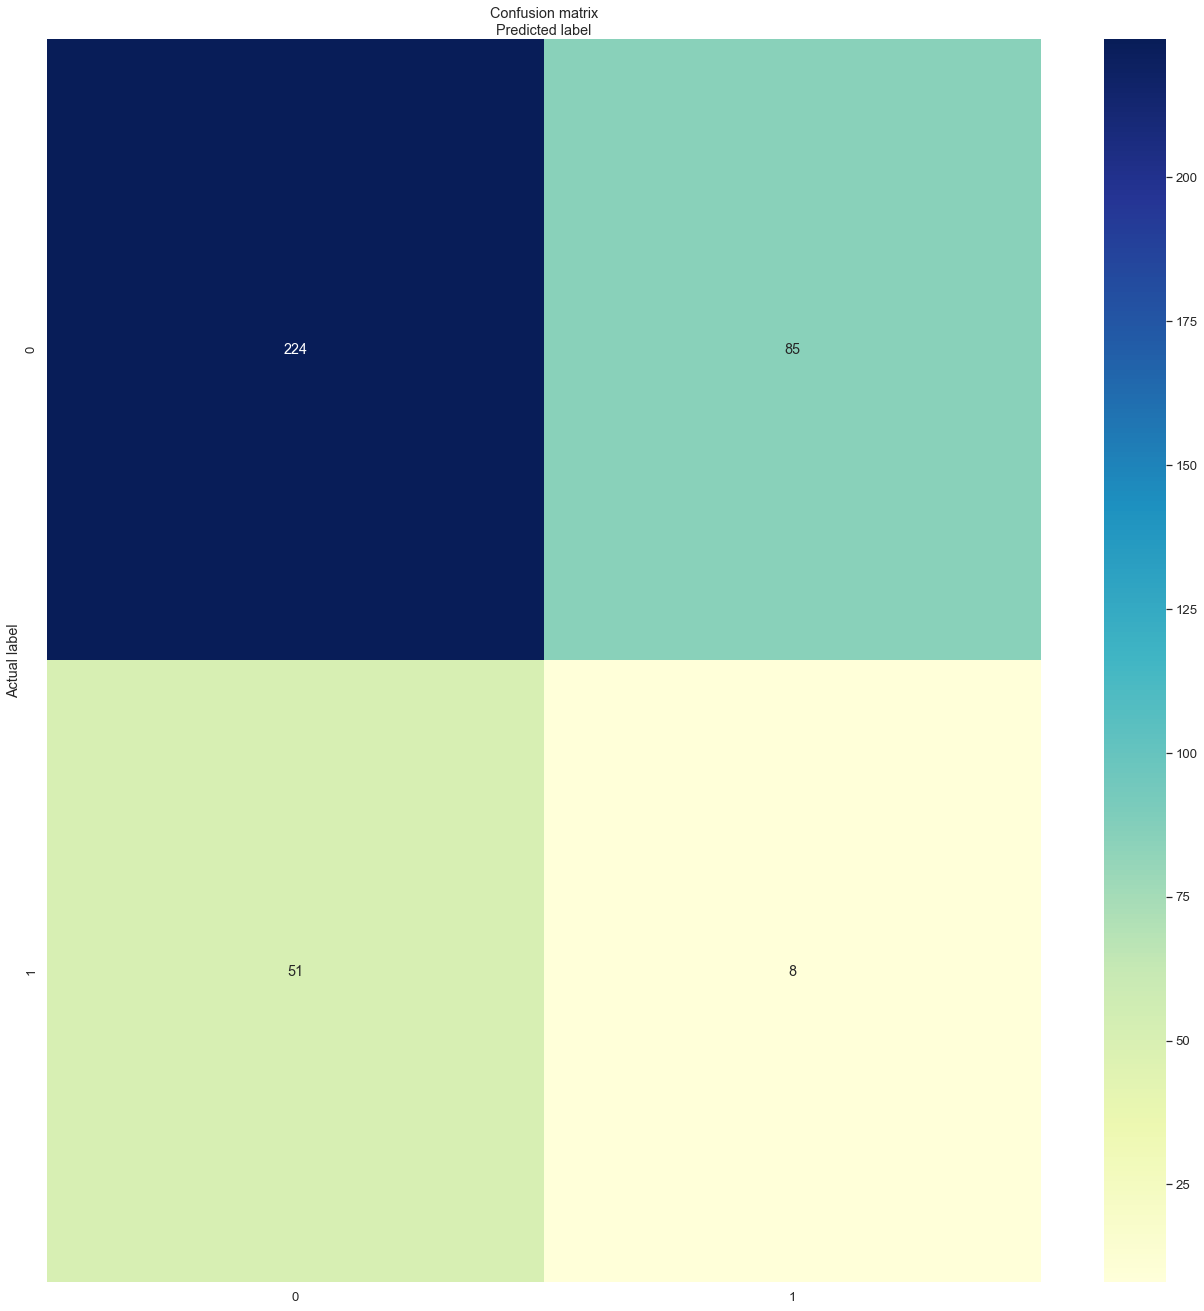

In [49]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [50]:
# instantiate the model (using the default parameters)
model_lr = LogisticRegression()

# fit the model with data
model_lr.fit(X_train_lr, y_train)

# generate test predictions with the model
y_prob = model_lr.predict_proba(X_test_lr)[:, 0]

threshold = .9
y_pred = np.where(y_prob > threshold, 1, 0)

In [51]:
acc_lr = round(model_lr.score(X_test_lr, y_test)*100, 2)
print(str(acc_lr) + ' percent')

83.97 percent


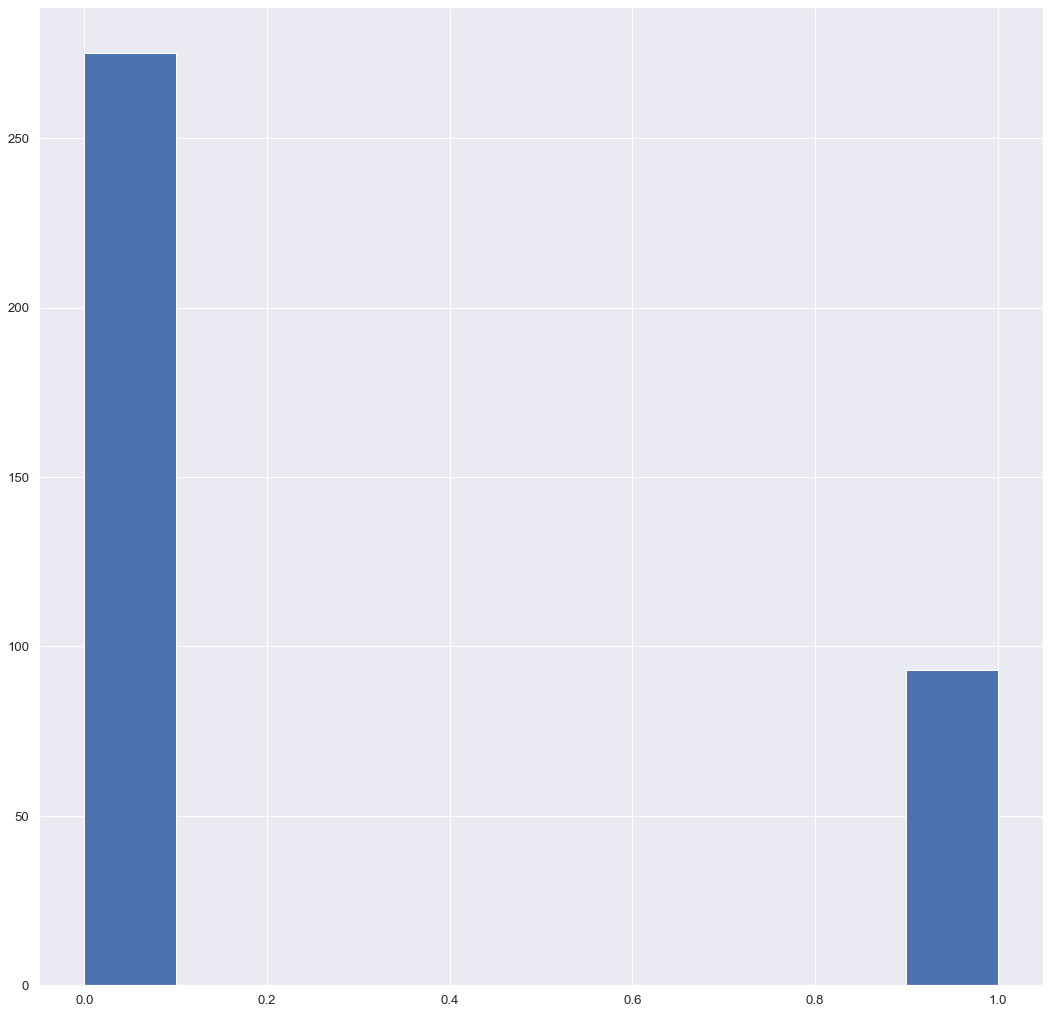

In [52]:
pd.Series(y_pred).hist()

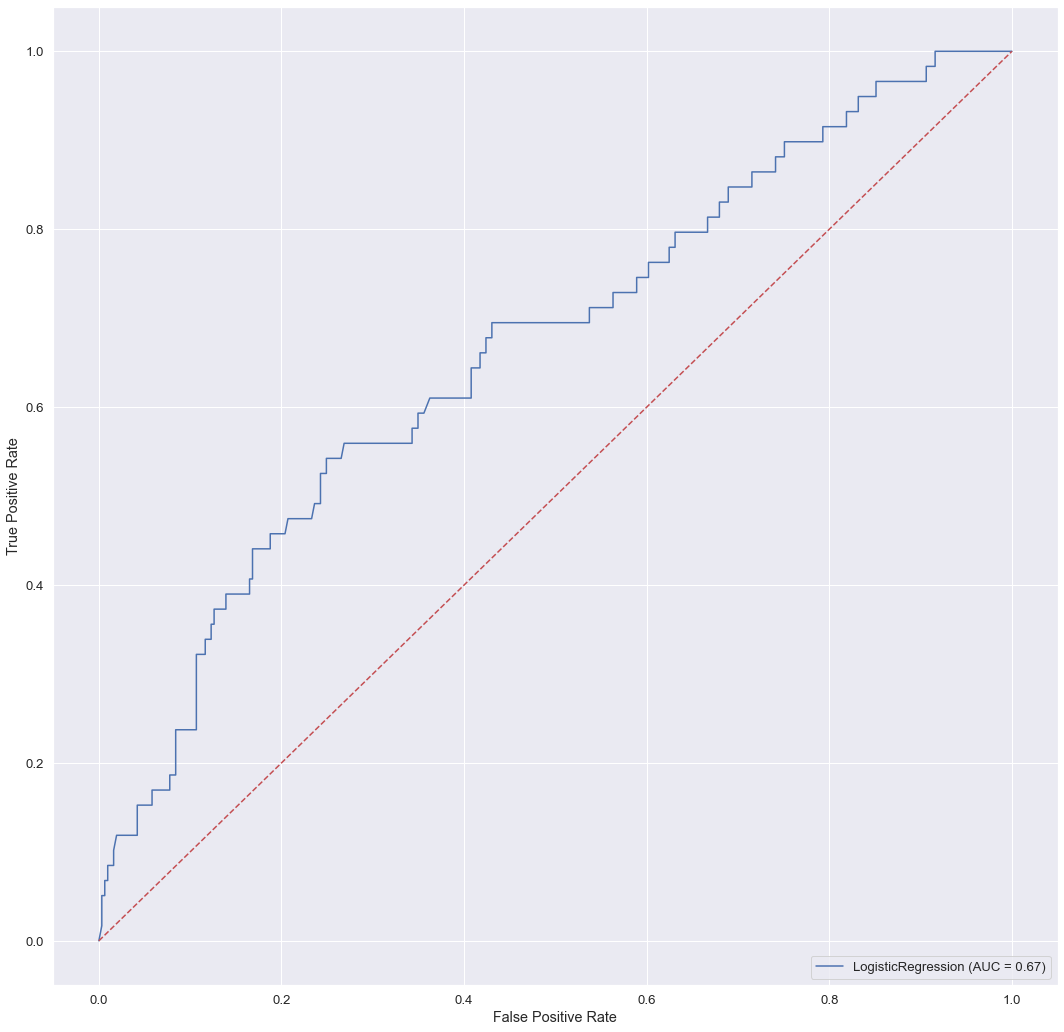

In [53]:
metrics.plot_roc_curve(model_lr, X_test_lr, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Text(0.5, 1144.48, 'Predicted label')

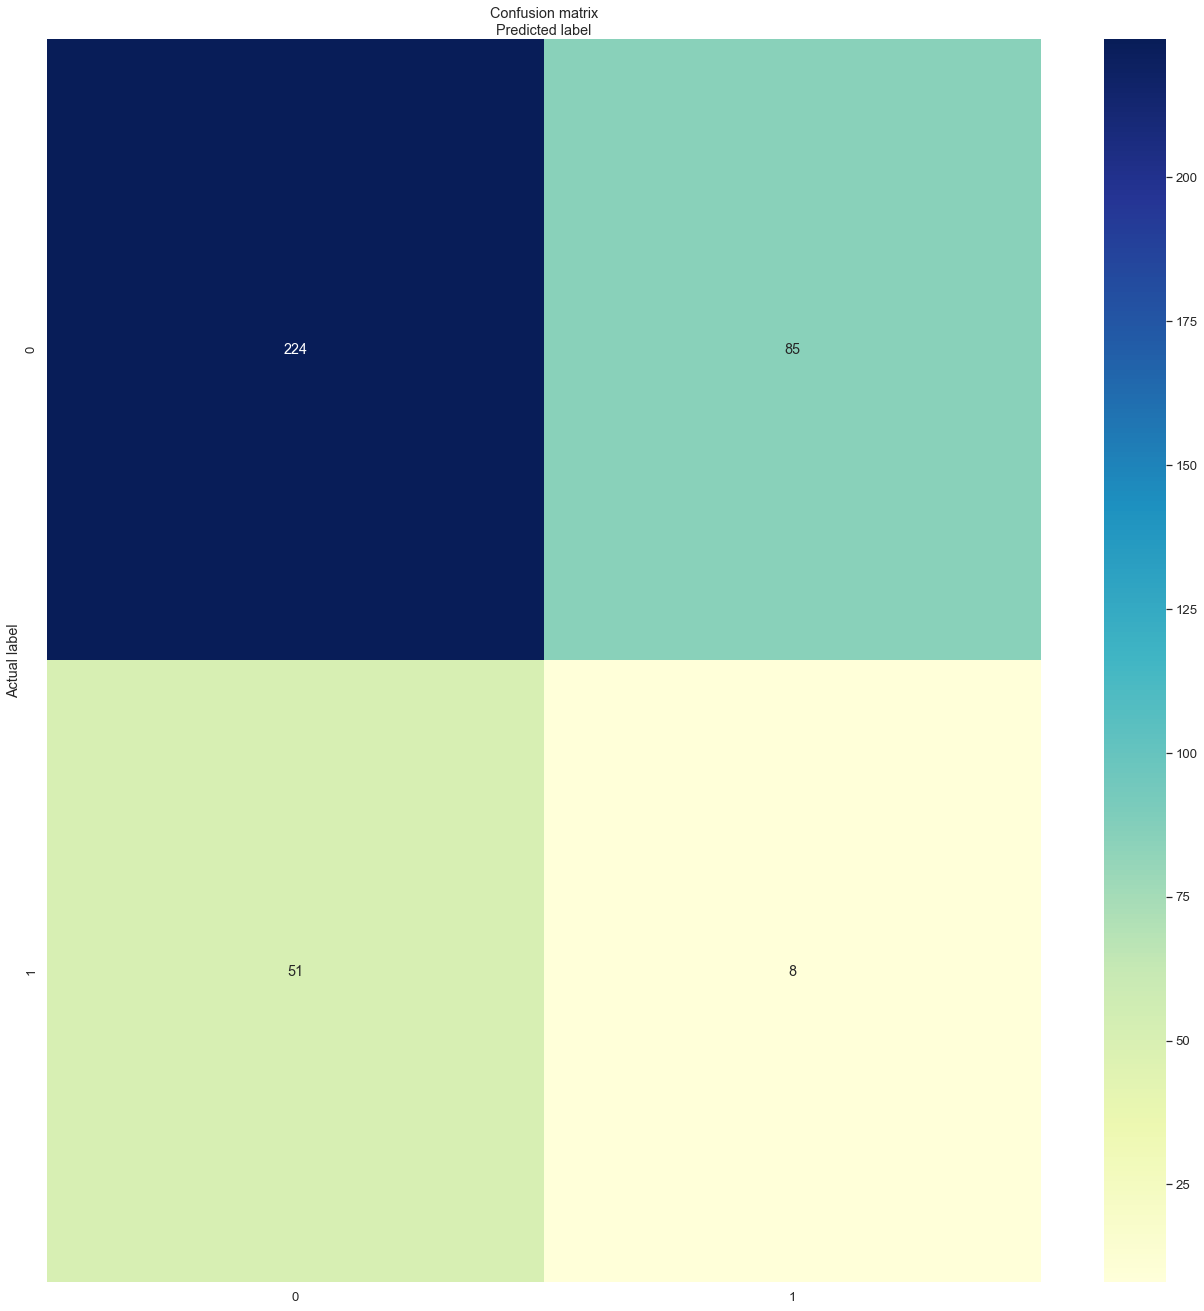

In [54]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Step 6: Non-linear classification models

### Bootstrap Aggregation (Bagging)

In [55]:
X_train_no_att = X_train.drop(['Attrition'], axis = 1)
X_test_no_att = X_test.drop(['Attrition'], axis = 1)

KeyError: "['Attrition'] not found in axis"

In [56]:
bag = BaggingClassifier()

bag.fit(X_train_no_att, y_train)

NameError: name 'X_train_no_att' is not defined

In [57]:
bag_y = bag.predict(X_test_no_att)

NameError: name 'X_test_no_att' is not defined

In [58]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(bag, X_test_no_att, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

NameError: name 'X_test_no_att' is not defined

## Step 7: Graph analysis

### Churn Predictions and Rates

In [ ]:
#Let's take a look at the churn rates for different features
ts = df[['Age','Attrition']].groupby(['Age']).mean().plot(figsize=(15,5), kind = 'bar')
ts.plot(figsize=(15,5), kind = 'bar', title = 'Attrition by Age')
pass

In [ ]:
ts = df[['Gender','Attrition']].groupby(['Gender']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Gender')
pass

In [ ]:
ts = df[['JobSatisfaction','Attrition']].groupby(['JobSatisfaction']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Job Satisfaction')
pass

In [ ]:
ts = df[['JobLevel','Attrition']].groupby(['JobLevel']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Job Level')
pass

In [ ]:
ts = df[['NumCompaniesWorked','Attrition']].groupby(['NumCompaniesWorked']).mean()
ts.plot(figsize=(10,5), kind = 'bar', title = 'Attrition by Number of Companies Worked')
pass

In [ ]:
ts = df[['EnvironmentSatisfaction','Attrition']].groupby(['EnvironmentSatisfaction']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Environment Satisfaction')
pass

In [ ]:
ts = df[['JobInvolvement','Attrition']].groupby(['JobInvolvement']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Job Involvement')
pass

In [ ]:
ts = df[['OverTime','Attrition']].groupby(['OverTime']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Overtime')
pass

In [ ]:
ts = df[['PerformanceRating','Attrition']].groupby(['PerformanceRating']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Performance Rating')
pass

In [ ]:
ts = df[['RelationshipSatisfaction','Attrition']].groupby(['RelationshipSatisfaction']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Relationship Satisfaction')
pass

In [ ]:
ts = df[['StockOptionLevel','Attrition']].groupby(['StockOptionLevel']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Stock Option Level')
pass

In [ ]:
ts = df[['TotalWorkingYears','Attrition']].groupby(['TotalWorkingYears']).mean()
ts.plot(figsize=(20,5), kind = 'bar', title = 'Attrition by Total Working Years')
pass

In [ ]:
ts = df[['WorkLifeBalance','Attrition']].groupby(['WorkLifeBalance']).mean()
ts.plot(figsize=(5,5), kind = 'bar', title = 'Attrition by Work Life Balance')
pass

In [ ]:
ts = df[['YearsInCurrentRole','Attrition']].groupby(['YearsInCurrentRole']).mean()
ts.plot(figsize=(10,5), kind = 'bar', title = 'Attrition by Years In Current Role')
pass

In [ ]:
ts = df[['YearsSinceLastPromotion','Attrition']].groupby(['YearsSinceLastPromotion']).mean()
ts.plot(figsize=(15,5), kind = 'bar', title = 'Attrition by Years Since Last Promotion')
pass

## Step 8: Synthetic Minority Oversampling Technique (SMOTE)

In [50]:
#May have to import imbalanced-learn if not already on computer
#pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [63]:
import imblearn
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, classification_report 

In [156]:
from sklearn.model_selection import train_test_split 
X=df2.iloc[:,1:-1]
y=df2.iloc[:,0:1]

# split into 70:30 ration 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [157]:
# logistic regression object 
lr = LogisticRegression() 


# train the model on train set 
lr.fit(X_train, y_train) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       371
           1       0.00      0.00      0.00        70

    accuracy                           0.84       441
   macro avg       0.42      0.50      0.46       441
weighted avg       0.71      0.84      0.77       441



In [158]:
#SMOTE 'em if you got 'em
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 0, k_neighbors=20, sampling_strategy='auto')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 


lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.91      0.66      0.77       371
           1       0.27      0.66      0.38        70

    accuracy                           0.66       441
   macro avg       0.59      0.66      0.57       441
weighted avg       0.81      0.66      0.71       441



In [164]:
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train) 

In [165]:
# train the model on train set 
lr2 = LogisticRegression() 
lr2.fit(X_train_miss, y_train_miss) 
predictions = lr2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 


              precision    recall  f1-score   support

           0       0.84      0.33      0.47       371
           1       0.16      0.66      0.25        70

    accuracy                           0.38       441
   macro avg       0.50      0.49      0.36       441
weighted avg       0.73      0.38      0.44       441



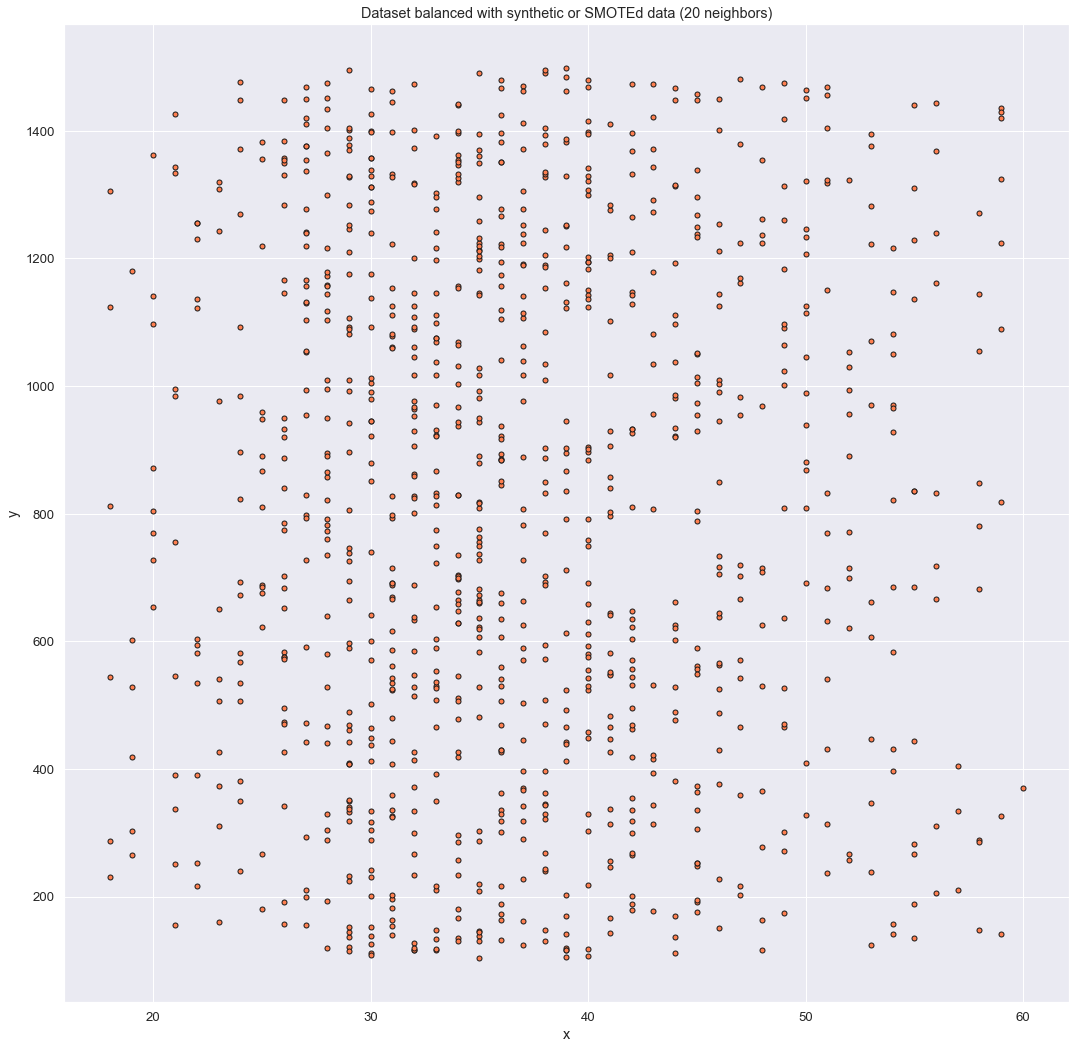

In [159]:
plt.title('Dataset balanced with synthetic or SMOTEd data ({} neighbors)'.format(20))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], marker='o', c='coral',
           s=25, edgecolor='k', cmap=plt.cm.coolwarm) # c=y_train_res,
plt.show()

#df2 = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res)], axis=1)
# rename the columns
#df2.columns = ['feature_1', 'feature_2', 'label']
#df2.to_csv('df_smoted.csv', index=False, encoding='utf-8')

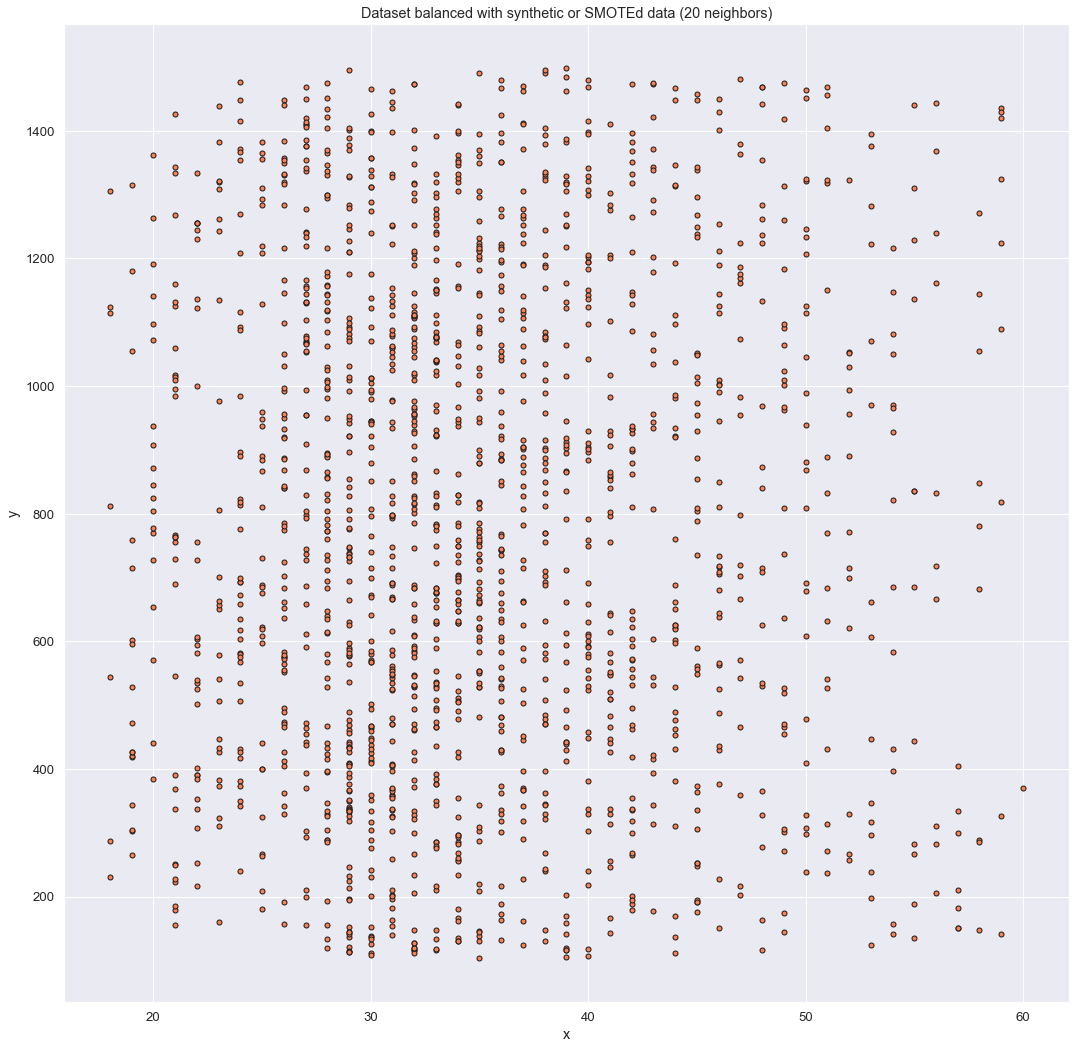

In [160]:
plt.title('Dataset balanced with synthetic or SMOTEd data ({} neighbors)'.format(20))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X_train_res.iloc[:, 0], X_train_res.iloc[:, 1], marker='o', c='coral',
           s=25, edgecolor='k', cmap=plt.cm.coolwarm) # c=y_train_res,
plt.show()

#df2 = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res)], axis=1)
# rename the columns
#df2.columns = ['feature_1', 'feature_2', 'label']
#df2.to_csv('df_smoted.csv', index=False, encoding='utf-8')